In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import random
import datetime

import numpy as np
import folium
import pandas as pd
import xarray as xr
from folium import plugins
from ocean_navigation_simulator.env.data_sources.DrifterData import DrifterData
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import lux
import os

dataset_drifter = {
    'host': 'nrt.cmems-du.eu',#ftp host => nrt.cmems-du.eu for Near Real Time products
    'product': 'INSITU_GLO_UV_NRT_OBSERVATIONS_013_048',#name of the In Situ Near Real Time product in the GLO area
    'name': 'drifter',# name of the dataset available in the above In Situ Near Real Time product
    'index_files': ['index_latest.txt', 'index_monthly.txt', 'index_history.txt'], #files describing the content of the lastest, monthly and history netCDF file collections available withint he above dataset
    'index_platform': 'index_platform.txt', #files describing the network of platforms contributing with files in the above collections
}
dataset_argo = {
    'host': 'nrt.cmems-du.eu',#ftp host => nrt.cmems-du.eu for Near Real Time products
    'product': 'INSITU_GLO_UV_NRT_OBSERVATIONS_013_048',#name of the In Situ Near Real Time product in the GLO area
    'name': 'argo',# name of the dataset available in the above In Situ Near Real Time product
    'index_files': ['index_history.txt'], #files describing the content of the lastest, monthly and history netCDF file collections available withint he above dataset
}

# define initial area of interest in order to increase speed
targeted_geospatial_lat_min = 25.0  # enter min latitude of your bounding box
targeted_geospatial_lat_max = 30.0  # enter max latitude of your bounding box
targeted_geospatial_lon_min = -120.0 # enter min longitude of your bounding box
targeted_geospatial_lon_max = -130.0 # enter max longitude of your bounding box
targeted_bbox = [targeted_geospatial_lon_min, targeted_geospatial_lat_min, targeted_geospatial_lon_max, targeted_geospatial_lat_max]  # (minx [lon], miny [lat], maxx [lon], maxy [lat])

# define intial time range of interest
targeted_time_range = '2021-01-01T00:00:00Z/2021-01-31T23:59:59Z'

config = {
    'data_dir': '/home/jonas/Documents/Thesis/OceanPlatformControl/data',
    'dataset': dataset_drifter,
    'targeted_bbox': targeted_bbox,
    'area_overlap_type': 'intersects',
    'targeted_time_range': targeted_time_range,
    'usr': "mmariuswiggert",
    "pas": "tamku3-qetroR-guwneq"
}

In [35]:
# Vis location of bbox
x_loc = (targeted_bbox[0]+ targeted_bbox[2])/2
y_loc = (targeted_bbox[1]+ targeted_bbox[3])/2
f = folium.Figure(width=500, height=500)
m = folium.Map(location=[y_loc, x_loc], zoom_start=4).add_to(f)
points = [(targeted_bbox[1], targeted_bbox[0]), (targeted_bbox[3], targeted_bbox[2])]
folium.Rectangle(bounds=points, color='#ff7800').add_to(m)
f

In [37]:
# download and load index files
drifter_data = DrifterData(config, read_only=False)
info = drifter_data.index_data
info.transpose()

...Downloading index_latest.txt
...Downloading index_monthly.txt
...Downloading index_history.txt
...Downloading index_platform.txt
...Loading info from: index_platform.txt
...Loading info from: index_latest.txt
...Loading info from: index_monthly.txt
...Loading info from: index_history.txt


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [38]:
# save pd for faster testing
path = os.path.join(config["data_dir"], "drifter_data", "index_data.csv")
info.to_csv(path)

In [40]:
# read in csv
path = os.path.join(config["data_dir"], "drifter_data", "index_data.csv")
info = pd.read_csv(path)
nc_links = info["file_name"].tolist()
info.shape

(59, 24)

In [41]:
# download all relevant files
nc_links = info["file_name"].tolist()
for i, file_link in enumerate(nc_links):
    drifter_data.downloadNCFile(file_link)

### Create pandas dataframe from drifter data

In [98]:
# pre-processing to minimise file size
file_list = [os.path.join(config["data_dir"], "drifter_data", "nc_files", file_link.split('/')[-1]) for file_link in nc_links]
start_time = datetime.datetime(2021,1,1)
end_time = datetime.datetime(2021,2,1)

column_names = ["time", "lon", "lat", "u", "v", "buoy"]
df = pd.DataFrame(columns = column_names)

for file_path in file_list[1:]:
    ds = DrifterData.readNCFile(file_path)

    # select specific data
    time = ds["TIME"].values
    lon = ds["LONGITUDE"].values
    lat = ds["LATITUDE"].values
    u = ds["NSCT"].isel(DEPTH=-1).values
    v = ds["EWCT"].isel(DEPTH=-1).values
    buoy = [file_path.split("/")[-1].split(".")[0] for i in range(len(time))]
    df_temp = pd.DataFrame({"time":time, "lon":lon, "lat":lat, "u":u, "v":v, "buoy":buoy})

    # filtering conditions
    lon_cond = ((df_temp["lon"] <= targeted_bbox[0]) & (df_temp["lon"] >= targeted_bbox[2]))
    lat_cond = ((df_temp["lat"] >= targeted_bbox[1]) & (df_temp["lat"] <= targeted_bbox[3]))
    time_cond = ((df_temp["time"] >= start_time) & (df_temp["time"] <= end_time))

    # filtering and concat to df
    df_temp = df_temp.loc[(lon_cond & lat_cond & time_cond)]
    df = pd.concat([df, df_temp])

    # change time column to datetime
    df["time"] = pd.to_datetime(df["time"])

# writing df to file
df.to_csv(os.path.join(config["data_dir"], "drifter_data", "drifter_data_2021_01.csv"), index=False)
print(df.shape)

(2458, 6)


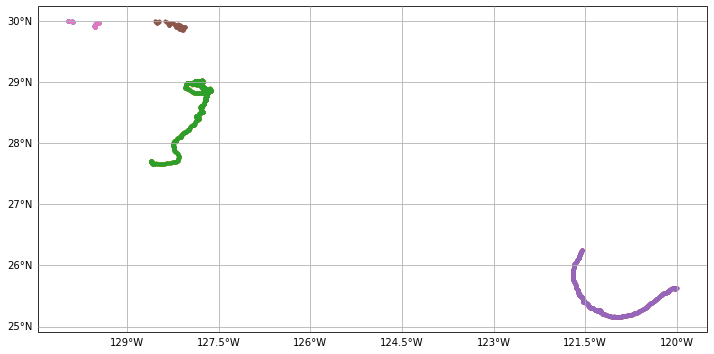

In [43]:
# setting up fig
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')

for buoy_name in set(df["buoy"]):
    ax.scatter(df[df["buoy"] == buoy_name]["lon"], df[df["buoy"] == buoy_name]["lat"], marker=".")

### Get hincasts from opendap

In [2]:
from ocean_navigation_simulator.env.data_sources.OceanCurrentField import OceanCurrentField
from ocean_navigation_simulator.env.utils import units

# Create the source dict for the ocean currents
source_dict = {'field': 'OceanCurrents'}
source_dict['source'] = 'opendap'
source_dict['source_settings'] = {
                   'service': 'copernicus',
                   'currents': 'total', # if we want to take the normal uo, vo currents or 'total' for tide, normal added
                   'USERNAME': 'mmariuswiggert', 'PASSWORD': 'tamku3-qetroR-guwneq',
                   # 'DATASET_ID': 'global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh',
                   'DATASET_ID': 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i'}

# What is this needed for?
sim_cache_dict = {'deg_around_x_t': 1, 'time_around_x_t': 3600 * 24 * 1}

In [3]:
# Create the ocean Field
ocean_field = OceanCurrentField(hindcast_source_dict=source_dict, sim_cache_dict=sim_cache_dict)

config["targeted_time_range"]
t_0 = datetime.datetime(2021, 1, 1, 1, 0, tzinfo=datetime.timezone.utc)
t_interval = [t_0, t_0 + datetime.timedelta(days=30)]
x_interval=[config["targeted_bbox"][2], config["targeted_bbox"][0]]
y_interval=[config["targeted_bbox"][1], config["targeted_bbox"][3]]

In [4]:
ds_hind = ocean_field.hindcast_data_source.get_data_over_area(x_interval, y_interval, t_interval)
ds_hind

<xarray.Dataset>
Dimensions:  (time: 722, lat: 63, lon: 122)
Coordinates:
  * lon      (lon) float32 -130.1 -130.0 -129.9 -129.8 ... -120.2 -120.1 -120.0
  * lat      (lat) float32 24.92 25.0 25.08 25.17 ... 29.83 29.92 30.0 30.08
    depth    float32 0.494
  * time     (time) datetime64[ns] 2021-01-01T00:30:00 ... 2021-01-31T01:30:00
Data variables:
    water_u  (time, lat, lon) float32 ...
    water_v  (time, lat, lon) float32 ...
Attributes: (12/19)
    product:                       GLOBAL_ANALYSIS_FORECAST_PHY_001_024
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    title:                         hourly mean merged surface currents from o...
    area:                          GLOBAL
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    ...                            ...
    institution:                   MERCATOR OCEAN
    julian_day_unit:               hours since 1950-01-01 00:00:00
    latitude_min:                  -80
    latitude_max:                  90.0
    longitude_min:                 -180.0
    longitude_max:                 179.91667175293

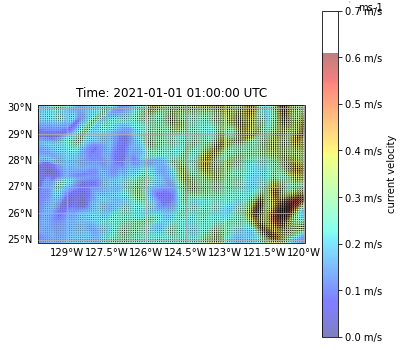

In [46]:
# different xarray plot types: streamline, quiver, ...
ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=t_0, x_interval=x_interval, y_interval=y_interval,
    plot_type='quiver', return_ax=False)

### Multi-dimensional interpolation

In [7]:
def interp_hindcast(df, n=10):
    print(df.shape)

    from tqdm import tqdm

    df["u_hind"] = 0
    df["v_hind"] = 0

    # convert time column to datetime
    df["time"] = pd.to_datetime(df["time"])

    for i in tqdm(range(0, df.shape[0], n)):
        # hindcast_interp = ds_hind.interp(time=df.iloc[i:i+n]["time"],
        #                                 lon=df.iloc[i:i+n]["lon"],
        #                                 lat=df.iloc[i:i+n]["lat"])

        hindcast_interp = ocean_field.hindcast_data_source.DataArray.interp(time=df.iloc[i:i+n]["time"],
                                                                            lon=df.iloc[i:i+n]["lon"],
                                                                            lat=df.iloc[i:i+n]["lat"])
        
        # add columns to dataframe
        df["u_hind"][i:i+n] = hindcast_interp["water_u"].values.diagonal().diagonal()
        df["v_hind"][i:i+n] = hindcast_interp["water_v"].values.diagonal().diagonal()

    return df

# df = interp_hindcast(df)
# # compute error columns
# df["u_error"] = df["u_hind"] - df["u"]
# df["v_error"] = df["v_hind"] - df["v"]

# # writing df to file
# df.to_csv(os.path.join(config["data_dir"], "drifter_data", "current_error_2021_01.csv"), index=False)

In [8]:
df_nan = df[df["u_hind"].isna() == True]
df_nan = interp_hindcast(df_nan)
print(df_nan.isna().sum())
df.shape

(117, 10)


 50%|█████     | 6/12 [04:35<04:35, 45.93s/it]


KeyboardInterrupt: 

In [20]:
frames = [df, df_nan]
df = pd.concat(frames)
df.isna().sum()

time         0
lon          0
lat          0
u            0
v            0
buoy         0
u_hind     234
v_hind     234
u_error    234
v_error    234
dtype: int64

In [39]:
df.to_csv(os.path.join(config["data_dir"], "drifter_data", "current_error_2021_01.csv"), index=False)

In [50]:
# load previous csv
df = pd.read_csv(os.path.join(config["data_dir"], "drifter_data", "current_error_2021_01.csv"))
print(f"count NaN rows: {df['u_hind'].isna().sum()}")

count NaN rows: 117


In [ ]:
# RMSE
def calc_speed_RMSE(u_data_hindcast, v_data_hindcast, u_data_measured, v_data_measured):
    RMSE_speed = np.sqrt((u_data_hindcast-u_data_measured)**2 + (v_data_hindcast-v_data_measured)**2)
    return RMSE_speed

df["RMSE_speed"] = calc_speed_RMSE(df["u_hind"], df["v_hind"], df["u"], df["v"])

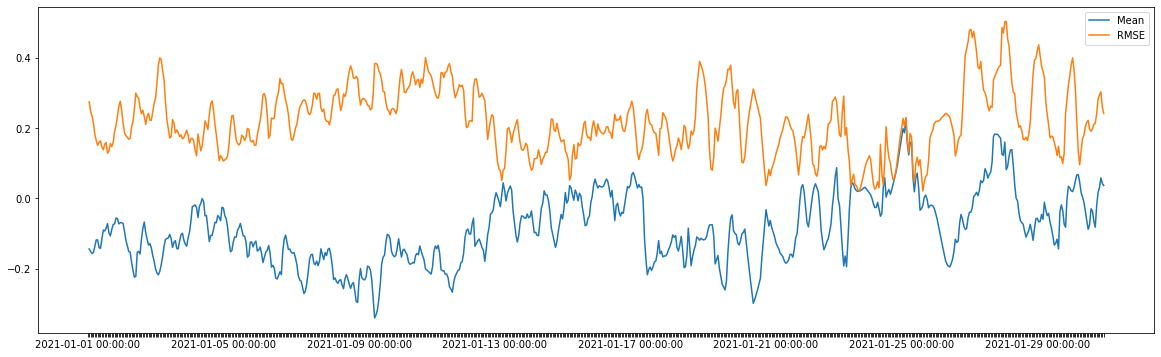

In [58]:
# mean current error vs time
df_filt = df[df["time"] < "2021-01-31"]
df_filt_group = df_filt.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
plt.locator_params(axis='x', nbins=7)
plt.plot(df_filt_group["time"], (df_filt_group["u_error"]*np.cos(np.pi/4) + df_filt_group["v_error"]*np.cos(np.pi/4)), label="Mean")
plt.plot(df_filt_group["time"], df_filt_group["RMSE_speed"], label="RMSE")
plt.legend()

# needed to supress most labels
every_nth = 96
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

In [32]:
"""
For VC:
need to iterate over buoy trajectories and over time
calc VC for one points in space and time
"""
example_point = df.iloc[0]
hindcast_vec = np.array([[example_point["u_hind"]], [example_point["v_hind"]]])
measured_vec = np.array([[example_point["u"]], [example_point["v"]]])

# calc correlation matrix
full_variable_vec = np.vstack((hindcast_vec, measured_vec))
print(full_variable_vec.shape)
# Covariance_matrix = np.cov(full_variable_vec, rowvar=0)

Sigma_11 = Covariance_matrix[:2,:2]
Sigma_22 = Covariance_matrix[2:,2:]
Sigma_12 = Covariance_matrix[:2,2:]
Sigma_21 = Covariance_matrix[2:,:2]

print(Covariance_matrix)

vector_correlation = np.trace(np.linalg.inv(Sigma_11) @ Sigma_12 @ np.linalg.inv(Sigma_22) @ Sigma_21)
print("vector_correlation is : ", vector_correlation)

(4, 1)


IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

TypeError: Length of y (2335) must match number of rows in z (2)

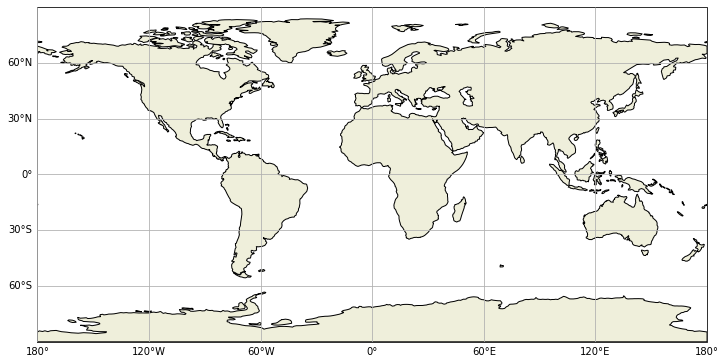

In [60]:
# spatial plot of error
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')

df["RMSE_speed"]
df_spatial = df_filt.groupby(by=["time", "buoy"], as_index=False).mean()
plt.contour(df_spatial["lon"], df_spatial["lat"], np.array([df_spatial["u_error"], df_spatial["v_error"]]))